# Logistic Regression: A Sentiment Analysis Case Study

### Introduction
___

- IMDB movie reviews dataset
- https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
- Contains 50000 Movie reviews
<img src="https://i.imgur.com/lQNnqgi.png" align="center">
- Contains at most reviews per movie
- At least 7 stars out of 10 $\rightarrow$ positive (label = 1)
- At most 4 stars out of 10 $\rightarrow$ negative (label = 0)
- 50/50 train/test split
- Evaluation accuracy

 <b>Model: Logistic regression</b>
- $p(y = 1|x) = \sigma(w^{T}x)$
- Linear classification model
- Can handle sparse data
- Fast to train
- Weights can be interpreted
<img src="https://i.imgur.com/VieM41f.png" align="center" width=500 height=500>

### Task 1: Loading the dataset
---

In [1]:
import pandas as pd

In [2]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('IMDB_Dataset.csv')


In [4]:
df, NAlist = reduce_mem_usage(df)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 0.7630615234375  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.7630615234375  MB
This is  100.0 % of the initial size
_________________

_________________

[]


In [5]:
df.columns

Index(['review', 'sentiment'], dtype='object')

# Exploratory data analysis

In [6]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [7]:
df.shape

(50000, 2)

In [8]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

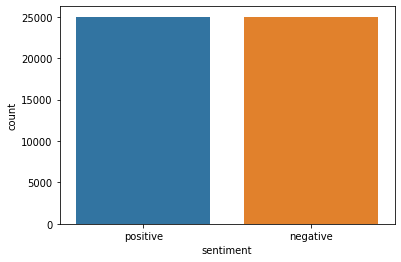

In [9]:
sns.countplot(x='sentiment', data=df)

## World cloud for negative reviews

In [10]:
from wordcloud import WordCloud, STOPWORDS

In [11]:
import sys
print(sys.executable)

C:\Users\Anant\anaconda3\python.exe


In [12]:
rev_df = df.loc[df['sentiment']=='negative', :]

rev_df.head(10)

,review,sentiment
3,Basically there's a family where a little boy ...,negative
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
10,Phil the Alien is one of those quirky films wh...,negative
11,I saw this movie when I was about 12 when it c...,negative
12,So im not a big fan of Boll's work but then ag...,negative
13,The cast played Shakespeare.<br /><br />Shakes...,negative
15,"Kind of drawn in by the erotic scenes, only to...",negative
17,This movie made it into one of my top 10 most ...,negative
19,An awful film! It must have been up against so...,negative


In [13]:
rev_df['sentiment'].value_counts()

negative    25000
Name: sentiment, dtype: int64

In [14]:
words = ' '.join(rev_df['review'])

print(words[:2000])

Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them. This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the 

In [15]:
cleaned_word = " ".join([word for word in words.split()
                            if 'br' not in word
                                and not word.startswith('<br /><br />')
                                and word != '<br /><br />'
                            ])

In [16]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(cleaned_word)

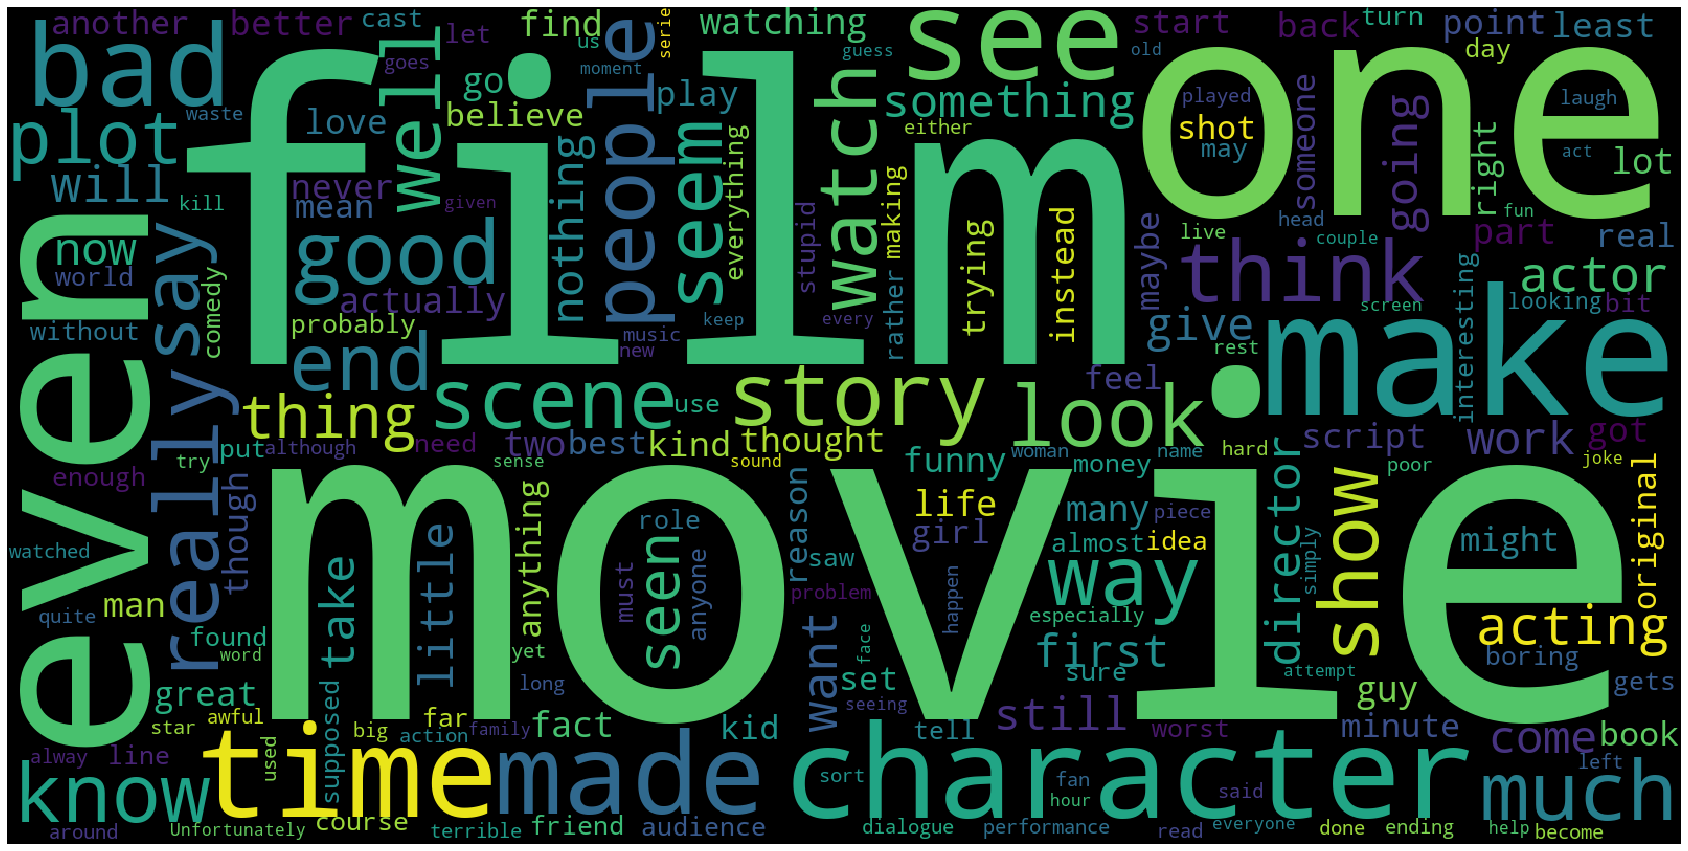

In [17]:
plt.figure(1,figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [18]:
rev_df = df.loc[df['sentiment']=='positive', :]
rev_df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
9,If you like original gut wrenching laughter yo...,positive
14,This a fantastic movie of three prisoners who ...,positive
16,Some films just simply should not be remade. T...,positive
18,"I remember this film,it was the first film i h...",positive


One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

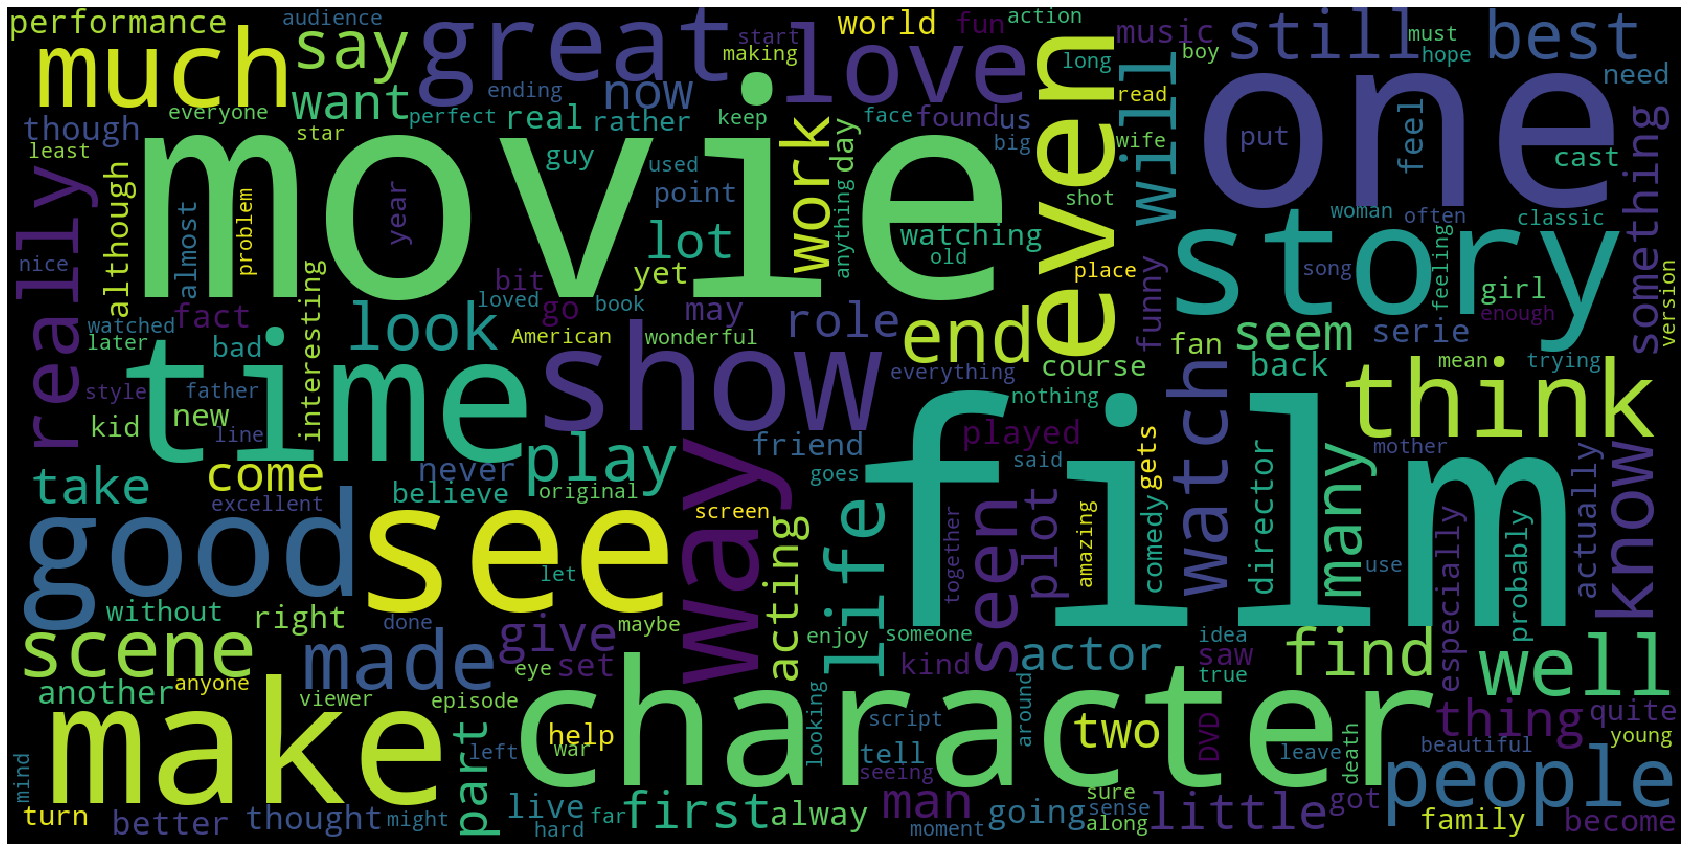

In [19]:
pwords = ' '.join(rev_df['review'])

print(pwords[:2000])

cleaned_word = " ".join([word for word in pwords.split()
                            if 'br' not in word
                                and not word.startswith('<br /><br />')
                                and word != '<br /><br />'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1600,
                      height=800
                     ).generate(cleaned_word)

plt.figure(1,figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Data Preprocessing

### Our data exploration ends here. The next step will be preprocess the data in order to make the learning process more smooth.

### Preprocessing steps:

#### Removing special characters
#### Convert sentence into lower case
#### Remove Stop Words
#### Stemming or Lemmatization

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [22]:
## initialise the inbuilt Stemmer
stemmer = PorterStemmer()

In [23]:
# # We can also use Lemmatizer instead of Stemmer

lemmatizer = WordNetLemmatizer()

In [24]:
# initializing the lists

clean_review_lst = []

review_len_lst = []

In [25]:
def preprocess(raw_review, flag):
    # Removing special characters and digits
    letters_only = re.sub("[^a-zA-Z]", " ",raw_review)
    
    # change sentence to lower case
    letters_only = letters_only.lower()

    # tokenize into words
    words = letters_only.split()
    
    # remove stop words                
    words = [w for w in words if not w in stopwords.words("english")]
    
    #Stemming/Lemmatization
    if(flag == 'stem'):
        words = [stemmer.stem(word) for word in words]
    else:
        words = [lemmatizer.lemmatize(word) for word in words]
    
    clean_review_lst.append(" ".join(words))
    
    review_len_lst.append(len(words))

##### Stemming makes sure that different variations of a word, say ‘warm’, warmer’, ‘warming’ and ‘warmed,’ are represented by a single token - ‘warm’, because they all represent the same information (represented by the 'stem' of the word).



In [26]:
from tqdm import tqdm, tqdm_notebook

tqdm.pandas()

C:\Users\Anant\anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [27]:
clean_review_lst = []

review_len_lst = []

df['review'].progress_apply(lambda x: preprocess(x, 'stem'))

df['clean_review_stem'] = clean_review_lst

df['review_length_stem'] = review_len_lst

100%|██████████| 50000/50000 [1:02:23<00:00, 13.36it/s]


In [30]:
df.head(10)

,review,sentiment,clean_review_stem,review_length_stem
0,One of the other reviewers has mentioned that ...,positive,one review mention watch oz episod hook right ...,168
1,A wonderful little production. <br /><br />The...,positive,wonder littl product br br film techniqu unass...,92
2,I thought this was a wonderful way to spend ti...,positive,thought wonder way spend time hot summer weeke...,88
3,Basically there's a family where a little boy ...,negative,basic famili littl boy jake think zombi closet...,70
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visual stun film...,133
5,"Probably my all-time favorite movie, a story o...",positive,probabl time favorit movi stori selfless sacri...,54
6,I sure would like to see a resurrection of a u...,positive,sure would like see resurrect date seahunt ser...,74
7,"This show was an amazing, fresh & innovative i...",negative,show amaz fresh innov idea first air first yea...,80
8,Encouraged by the positive comments about this...,negative,encourag posit comment film look forward watch...,64
9,If you like original gut wrenching laughter yo...,positive,like origin gut wrench laughter like movi youn...,19


  3%|▎         | 1532/50000 [02:10<1:19:25, 10.17it/s]

In [29]:
nltk.download('wordnet')
clean_review_lst = []

review_len_lst = []

df['review'].progress_apply(lambda x: preprocess(x, 'lemma'))

df['clean_review_lemma'] = clean_review_lst

df['review_length_lemma'] = review_len_lst

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Anant\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
  0%|          | 90/50000 [00:09<1:19:26, 10.47it/s]Exception ignored in: <function SeekableUnicodeStreamReader.__del__ at 0x0000025C1D7ABA68>
Traceback (most recent call last):
  File "C:\Users\Anant\anaconda3\lib\site-packages\nltk\data.py", line 1281, in __del__
    self.close()
  File "C:\Users\Anant\anaconda3\lib\site-packages\nltk\data.py", line 1310, in close
    self.stream.close()
KeyboardInterrupt
  3%|▎         | 1529/50000 [01:54<1:19:26, 10.17it/s]

KeyboardInterrupt: 

In [ ]:
df.head(10)

## Data preparation

#### Let's now prepare the data and build the model.

In [31]:
# Preparing the target variable

df['review_sentiment']=df['sentiment'].apply(lambda x: 0 if x=='negative' else 1)

df.head()

,review,sentiment,clean_review_stem,review_length_stem,review_sentiment
0,One of the other reviewers has mentioned that ...,positive,one review mention watch oz episod hook right ...,168,1
1,A wonderful little production. <br /><br />The...,positive,wonder littl product br br film techniqu unass...,92,1
2,I thought this was a wonderful way to spend ti...,positive,thought wonder way spend time hot summer weeke...,88,1
3,Basically there's a family where a little boy ...,negative,basic famili littl boy jake think zombi closet...,70,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visual stun film...,133,1


In [32]:
# splitting into test and train

from sklearn.model_selection  import train_test_split

train, test = train_test_split(df,test_size=0.2,random_state=42)

In [33]:
train_clean_review=[]
for review in train['clean_review_stem']:
    train_clean_review.append(review)

test_clean_review=[]
for review in test['clean_review_stem']:
    test_clean_review.append(review)

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2))

train_features = vectorizer.fit_transform(train_clean_review)

test_features = vectorizer.transform(test_clean_review)

In [35]:
vectorizer.vocabulary_

{'kept': 1051897,
 'ask': 113296,
 'mani': 1194937,
 'fight': 713714,
 'scream': 1698507,
 'match': 1210662,
 'swear': 1920564,
 'gener': 800950,
 'mayhem': 1218803,
 'permeat': 1445349,
 'minut': 1254016,
 'comparison': 383946,
 'also': 57562,
 'stand': 1847251,
 'think': 1967279,
 'one': 1376258,
 'dimension': 520685,
 'charact': 315407,
 'littl': 1138403,
 'depth': 497829,
 'virtual': 2107842,
 'imposs': 971130,
 'care': 286520,
 'happen': 880114,
 'badli': 147325,
 'written': 2200313,
 'cypher': 458183,
 'director': 524586,
 'hang': 878972,
 'multicultur': 1298753,
 'belief': 176789,
 'topic': 2003627,
 'done': 546922,
 'much': 1294809,
 'better': 187187,
 'drama': 556129,
 'tv': 2039476,
 'cinema': 341893,
 'br': 229375,
 'must': 1304975,
 'confess': 394705,
 'realli': 1578851,
 'spot': 1840916,
 'bad': 144789,
 'perform': 1440221,
 'film': 717281,
 'said': 1668138,
 'nichola': 1335086,
 'burley': 264063,
 'heroin': 908266,
 'slutti': 1797988,
 'best': 184424,
 'friend': 775507,
 

In [40]:
print("Total unique words:", len(vectorizer.vocabulary_))

print("Type of train_features:", type(train_features))

print("Shape of input data", train_features.shape)


Total unique words: 2220022
Type of train_features: <class 'scipy.sparse.csr.csr_matrix'>
Shape of input data (40000, 2220022)


# Model Building and Evaluation

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

In [42]:

Classifiers = [
    LogisticRegression()]
# dense_features = train_features.toarray()

# dense_test = test_features.toarray()

for classifier in tqdm(Classifiers):
    fit = classifier.fit(train_features,train['sentiment'])
    pred = fit.predict(test_features)
    accuracy = accuracy_score(pred,test['sentiment'])
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy))



  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Anant\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


100%|██████████| 1/1 [00:54<00:00, 54.49s/it]

Accuracy of LogisticRegression is 0.9014
